In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from data import RoadSatelliteModule
from system import SemanticSegmentationSystem

from models import *

import numpy as np
import matplotlib.pyplot as plt
import random

import torchvision
import torchvision.transforms.functional as F

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

import torch
from torchinfo import summary

import regex as re

In [3]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

# 1. Preparation

In [4]:
batch_size = 8
num_workers = 8

In [5]:
pl.seed_everything(7, workers=True)

Global seed set to 7


7

## 1.1 DataModule

In [6]:
road_data = RoadSatelliteModule(num_workers=num_workers, batch_size=batch_size)

In [7]:
%%time
X, y = next(iter(road_data.train_dataloader()))

CPU times: user 2.3 s, sys: 1.8 s, total: 4.1 s
Wall time: 5.89 s


In [8]:
imgs, masks = next(iter(road_data.test_dataloader()))

## 1.2 Inspect Data

In [9]:
def show_image(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

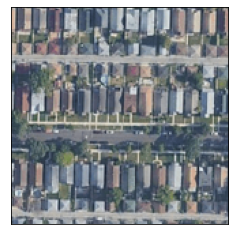

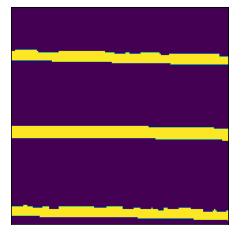

In [10]:
show_image(X[0])
show_image(y[0])

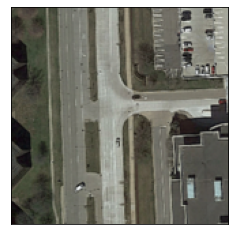

In [11]:
show_image(imgs[0][0])

# 2. Define Model / System

In [12]:
model = NestedUNet(1, 3)
model_name = str(model).partition('(')[0]

In [13]:
system = SemanticSegmentationSystem(model, road_data)

In [14]:
system = SemanticSegmentationSystem.load_from_checkpoint(f'{"./lightning_logs/" + model_name + "_data"}/{model_name + "_data"}.ckpt', model=model, datamodule=road_data)

In [15]:
system.freeze()

model_fix = UNet(1, 1)
model_name = str(model_fix).partition('(')[0]

In [16]:
system = SemanticSegmentationSystem(model, road_data, model_fix)

In [17]:
system = SemanticSegmentationSystem.load_from_checkpoint(f'{"./lightning_logs/" + model_name + "_fix_data"}/{model_name + "_fix_data"}.ckpt', model=model, datamodule=road_data, model_fix=model_fix)

In [14]:
system.freeze()

model_fix_mask = UNet(1, 1)
model_name = str(model_fix_mask).partition('(')[0]

In [15]:
system = SemanticSegmentationSystem(model, road_data, model_fix, model_fix_mask)

In [16]:
system = SemanticSegmentationSystem.load_from_checkpoint(f'{"./lightning_logs/"}/{model_name + "_fix-v16"}.ckpt', model=model, datamodule=road_data, model_fix=model_fix, model_fix_mask=model_fix_mask)

# 4. Training

In [18]:
if torch.cuda.is_available():
    gpu_count = -1
    gpu_auto_select = True
else:
    gpu_count = 0
    gpu_auto_select = False

In [19]:
checkpoint_callback = ModelCheckpoint(
    monitor='validation_f1',
    dirpath='./lightning_logs',
    filename=model_name + '_fix',
    save_top_k=1,
    verbose=2,
    mode='max'
)

In [20]:
early_stop_callback = EarlyStopping(
   monitor='validation_f1',
   patience=50,
   verbose=1,
   mode='max'
)

In [21]:
trainer = pl.Trainer(
    #fast_dev_run=True,
    gpus=gpu_count,
    auto_select_gpus=gpu_auto_select,
    stochastic_weight_avg=True,
    benchmark=True,
    callbacks=[early_stop_callback, checkpoint_callback],
    
    resume_from_checkpoint=f'{"./lightning_logs/"}/{model_name + "_fix-v16"}.ckpt'
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [22]:
%%time
trainer.fit(system)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type       | Params
----------------------------------------------
0 | model          | NestedUNet | 2.3 M 
1 | model_fix      | UNet       | 2.0 M 
2 | model_fix_mask | UNet       | 2.0 M 
3 | dice_loss      | DiceLoss   | 0     
4 | upsample2x     | Upsample   | 0     
5 | upsample608    | Upsample   | 0     
6 | upsample48     | Upsample   | 0     
7 | upsample38     | Upsample   | 0     
----------------------------------------------
2.0 M     Trainable params
4.3 M     Non-trainable params
6.2 M     Total params
24.898    Total estimated model params size (MB)
Restored states from the checkpoint file at ./lightning_logs//UNet_fix-v16.ckpt


Validation sanity check: 0it [00:00, ?it/s]

KeyboardInterrupt: 

In [ ]:
if gpu_count != 0:
    model.cuda()
    model_fix.cuda()
    model_fix_mask.cuda()

In [ ]:
system.visualize_results()

In [ ]:
system.visualize_results_overlay()

# 5. Predict

In [374]:
system = SemanticSegmentationSystem.load_from_checkpoint(f'{"./lightning_logs/"}/{model_name + "_fix-v16"}.ckpt', model=model, datamodule=road_data, model_fix=model_fix, model_fix_mask=model_fix_mask)

In [ ]:
trainer.test(system, ckpt_path=f'{"./lightning_logs/"}/{model_name + "_fix-v16"}.ckpt')

In [22]:
system_no_fix = SemanticSegmentationSystem.load_from_checkpoint(f'{"./lightning_logs/" + model_name + "_fix_data"}/{model_name + "_fix_data"}.ckpt', model=model, datamodule=road_data, model_fix=model_fix)

In [64]:
trainer.test(system_no_fix, ckpt_path=f'{"./lightning_logs/" + model_name + "_fix_data"}/{model_name + "_fix_data"}.ckpt')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


[{}]

In [103]:
t = system_no_fix.test_results[6][0].clone()

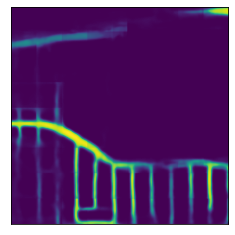

In [104]:
show_image(t)

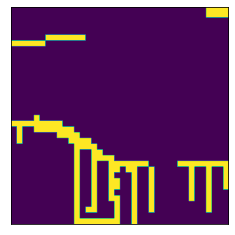

In [105]:
show_image(mask_to_patched_mask(t.cpu()))

In [106]:
import skimage

In [107]:
f = skimage.filters.threshold_multiotsu(t.cpu().numpy())

In [108]:
t[t > f[0]] = 1.0
t[t <= f[0]] = 0.0

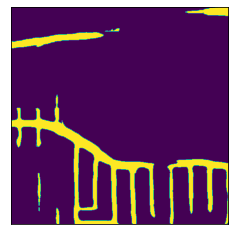

In [109]:
show_image(t)

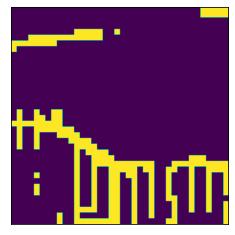

In [110]:
show_image(mask_to_patched_mask(t.cpu()))

In [341]:
f = skimage.filters.threshold_multiotsu(x[0].permute(2, 1, 0).numpy())

In [347]:
x[0][x[0] > f[0]] = 1.0
x[0][x[0] <= f[0]] = 0.0

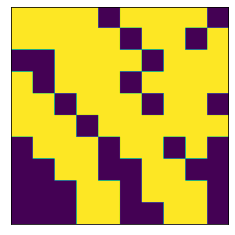

In [353]:
show_image(mask_to_patched_mask(x[0]))

In [291]:
f.shape

(160, 160, 1)

In [336]:
xx = skimage.restoration.denoise_wavelet(f.squeeze())

ValueError: convert2ycbcr requires multichannel == True

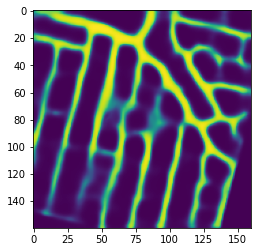

In [337]:
plt.imshow(xx)

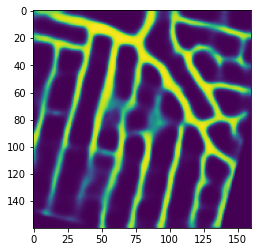

In [328]:
xx

array([[3.28147978e-01, 5.45349896e-01, 6.66183710e-01, ...,
        1.15412278e-02, 1.27051435e-02, 1.30194845e-02],
       [4.52564031e-01, 6.14880145e-01, 6.82712078e-01, ...,
        1.06930407e-02, 1.18912477e-02, 1.00513073e-02],
       [3.98178697e-01, 4.57567036e-01, 4.91677076e-01, ...,
        6.59330375e-03, 9.09582339e-03, 9.79734212e-03],
       ...,
       [4.83191619e-03, 2.94334558e-03, 1.75280310e-03, ...,
        2.40520749e-04, 5.91791293e-04, 1.05015992e-03],
       [5.32544404e-03, 3.41651007e-03, 2.46568373e-03, ...,
        6.71396323e-04, 5.05517237e-04, 1.67347747e-03],
       [6.53608330e-03, 4.62714955e-03, 3.51362699e-03, ...,
        1.25616929e-03, 1.88056636e-03, 3.42909503e-03]], dtype=float32)

In [373]:
import torch
from torch import nn

import torchmetrics as tm

import pytorch_lightning as pl

import numpy as np
import matplotlib.pyplot as plt
import random

import torchvision
import torchvision.transforms.functional as F
from torchvision.utils import draw_segmentation_masks

import scipy

class SemanticSegmentationSystem(pl.LightningModule):
    def __init__(self, model: nn.Module, datamodule: pl.LightningDataModule, model_fix: nn.Module = None, model_fix_mask: nn.Module = None, lr: float = 1e-3, batch_size: int = 8):        
        super().__init__()
        self.model = model
        self.datamodule = datamodule
        
        self.model_fix = model_fix
        self.model_fix_mask = model_fix_mask
        
        self.lr = lr
        self.batch_size = batch_size
        
        self.dice_loss = DiceLoss()

        self.test_results = None
        
        self.upsample2x = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.upsample608 = nn.Upsample(size=(608, 608), mode='bilinear', align_corners=True)
        self.upsample48 = nn.Upsample(size=(48, 48), mode='bilinear', align_corners=True)
        self.upsample38 = nn.Upsample(size=(38, 38), mode='bilinear', align_corners=True)

    def forward(self, X, predict=False):
        y_pred = self.model(X.float())
        
        if self.model_fix:
            y_pred = self.model_fix(torch.sigmoid(y_pred))        

        if self.model_fix_mask and not predict:
            y_pred = self.upsample608(torch.sigmoid(y_pred))

            y_pred_patched = get_patches_batch(y_pred)
            y_pred_patched_u = self.upsample48(y_pred_patched)
            y_pred = self.model_fix_mask(y_pred_patched_u)
            y_pred = self.upsample38(y_pred)

        return y_pred
        
    def training_step(self, batch, batch_idx):
        X, y = batch
        
        X = X.float()
        y = y.float()
        
        y_pred = self(X)

        if self.model_fix_mask:
            y_up = self.upsample608(y)
            y = get_patches_batch(y_up)
       
        loss = self.dice_loss(y_pred, y) + nn.functional.binary_cross_entropy_with_logits(y_pred, y, reduction='mean')
        
        self.log('training_loss', loss)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        X, y = batch
                
        X = X.float()
        y = y.float()

        if self.model_fix_mask:
            y_up = self.upsample608(y)
            y = get_patches_batch(y_up)

        y = y.int()
   
        y_pred = self(X)
        y_sig = torch.sigmoid(y_pred)
    
        accuracy = tm.functional.accuracy(y_sig, y)
        f1 = tm.functional.f1(y_sig, y)
        
        self.log('validation_accuracy', accuracy, prog_bar=True)
        self.log('validation_f1', f1, prog_bar=True)
        
        #show_image(y_sig[0]) 
        
        return f1
    
    def test_step(self, batch, batch_idx):
        X, names = batch
        
        y_preds = self.predict_test_batch(X)
        
        pred_zip = list(zip(y_preds, names))

        return pred_zip

    def test_epoch_end(self, outputs):
        self.test_results = [item for sublist in outputs for item in sublist]
        
    def predict_test_batch(self, X, angles=[0, 90, 180, 270]):
        X = X.float()
        y_preds_final = []

        for x in X:
            y_preds = []
  
            for angle in angles:
                x_rotated = self.rotate_patches(x, angle)
                y_pred = self.predict_patches(x_rotated, angle=-angle)
                return y_pred
                
                y_preds.append(y_pred)
                
            # Majority voting
            
            y_preds = torch.stack(y_preds)
            
            if self.model_fix_mask:
                y_preds = self.model_fix_mask(y_preds)
            
            masks_batch = []
            for mask_pred in y_preds:
                mask_pred_patched = mask_to_patched_mask(mask_pred.cpu())
                
                mask_pred_patched = torch.from_numpy(scipy.ndimage.binary_fill_holes(mask_pred_patched)).float()
                
                masks_batch.append(mask_pred_patched)

            masks_batch = torch.stack(masks_batch)

            masks_sum = masks_batch.sum(0)
            mask_maj = masks_sum.clone()

            mask_maj[masks_sum > len(angles) / 2] = 1.0
            mask_maj[masks_sum <= len(angles) / 2] = 0.0            
            
            y_preds_final.append(mask_maj)
            #y_preds_final.append(y_preds.mean(0))
        
        y_preds_final = torch.stack(y_preds_final)

        return y_preds_final
    
    def rotate_patches(self, patches, angle):
        patches_rotated = []
        
        for patch in patches:
            patch_rotated = F.rotate(patch, angle)
            
            patches_rotated.append(patch_rotated)
            
        return torch.stack(patches_rotated)
    
    def predict_patches(self, patches, H=600, W=600, angle=0):
        y_preds_patches = torch.sigmoid(self(patches, True))
        y_pred_patches = self.upsample2x(y_preds_patches)

        y_pred_patches = self.rotate_patches(y_pred_patches, angle)
        y_pred = self.restore_image_mask(y_pred_patches, H, W, 70, 5, 5)
        y_pred = self.upsample608(y_pred)[0]
        
        return y_pred
    
    @torch.no_grad()
    def visualize_results(self):
        Xs, ys = next(iter(self.val_dataloader()))
                
        y_preds = torch.sigmoid(self(Xs.float().cuda()))

        for y_pred in y_preds:
            show_image(y_pred)
           
    @torch.no_grad()
    def visualize_results_overlay(self, num_images=None):
        Xs, ys = next(iter(self.val_dataloader()))
                
        y_preds = torch.sigmoid(self(Xs.float().cuda()))
        
        imgs_masks_zip = list(zip(Xs, ys))
        seg_imgs_masks = [draw_segmentation_masks(train_pair[0], train_pair[1].bool(), alpha=0.6, colors=['#FF0000']) for train_pair in imgs_masks_zip]
        
        pred_zip = list(zip(seg_imgs_masks, y_preds))
        seg_imgs_pred = [draw_segmentation_masks(train_pair[0], train_pair[1].round().bool(), alpha=0.6, colors=['#00ff00']) for train_pair in pred_zip]
        
        for i, seg_image in enumerate(seg_imgs_pred):
            show_image(seg_image)

    def split_image(self, imgs, kernel_size=240, stride=80):
        if len(imgs.shape) < 4:
            imgs = imgs[None, :, :, :]
        
        B, C, H, W = imgs.shape
        
        patches = imgs.float().unfold(3, kernel_size, stride).unfold(2, kernel_size, stride).permute(0,1,2,3,5,4)
        
        return patches.contiguous().view(patches.shape[0], patches.shape[1], patches.shape[2] * patches.shape[3], patches.shape[4], patches.shape[5]).squeeze(0).transpose(1, 0).byte()
  
    def restore_image(self, patches, H=400, W=400, stride=80):
        B, C, _, _, kernel_size, _ = patches.shape
            
        patches = patches.contiguous().view(B, C, -1, kernel_size*kernel_size)
        patches = patches.permute(0, 1, 3, 2) 
        patches = patches.contiguous().view(B, C*kernel_size*kernel_size, -1)
            
        output = torch.nn.functional.fold(
            patches, output_size=(H, W), kernel_size=kernel_size, stride=stride)
            
        return output

    def restore_image_mask(self, patches, H=400, W=400, stride=80, num_patches_v=3, num_patches_h=3):
        patches = patches.transpose(1, 0).view(patches.shape[1], num_patches_v, num_patches_h, patches.shape[2], patches.shape[3]).unsqueeze(0)    

        B, C, _, _, kernel_size, _ = patches.shape
        
        restored_output = self.restore_image(patches, H, W, stride)
        
        ones = torch.ones((B, C, H, W), device='cuda')
        
        patches_ones = self.split_image(ones, kernel_size, stride).float()
        
        patches_ones = patches_ones.transpose(1, 0).view(patches_ones.shape[1], num_patches_v, num_patches_h, patches_ones.shape[2], patches_ones.shape[3]).unsqueeze(0)    
        
        restored_ones = self.restore_image(patches_ones, H, W, stride)
            
        return (restored_output / restored_ones)
            
    def train_dataloader(self):
        return self.datamodule.train_dataloader()

    def val_dataloader(self):
        return self.datamodule.val_dataloader()

    def test_dataloader(self):
        return self.datamodule.test_dataloader()
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 10, 2, 1e-6, verbose=0)
        
        return {
            'optimizer': optimizer,
            'lr_scheduler': scheduler,
            'monitor': 'validation_f1'
        }

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice
    
def show_image(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    
    plt.show()

def get_patches_from_image(img, size=5, stride=5):
    patches = img.unfold(1, size, stride).unfold(2, size, stride)
    
    return patches

def get_patches_averages_rgb(img, is_mask=False, size=5, stride=5):
    patches = get_patches_from_image(img, size, stride)
    
    patches_avg = patches.float().mean((3, 4))
    
    if is_mask:
        patches_avg[patches_avg > 0.25] = 1.0
        patches_avg[patches_avg <= 0.25] = 0.0
        
    return patches_avg

def get_patches_batch(imgs):
    imgs_patched = []
    
    for img in imgs:
        img_patched = get_patches_averages_rgb(img, True, 16, 16)
        
        imgs_patched.append(img_patched)
        
    return torch.stack(imgs_patched)


foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

# assign a label to a patch
def patch_to_label(patch):
    df = np.mean(patch)
    if df > foreground_threshold:
        return 1
    else:
        return 0
    
def mask_to_patched_mask(image):
    patched_image = image.squeeze().detach().clone()
    image = np.asarray(image.squeeze())
    patch_size = 16
    for j in range(0, image.shape[1], patch_size):
        for i in range(0, image.shape[0], patch_size):
            patch = image[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            patched_image[i:i + patch_size, j:j + patch_size] = label
    return patched_image

In [36]:
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

# assign a label to a patch
def patch_to_label(patch):
    df = np.mean(patch)
    if df > foreground_threshold:
        return 1
    else:
        return 0
    
def mask_to_patched_mask(image):
    patched_image = image.squeeze().detach().clone()
    image = np.asarray(image.squeeze())
    patch_size = 16
    for j in range(0, image.shape[1], patch_size):
        for i in range(0, image.shape[0], patch_size):
            patch = image[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            patched_image[i:i + patch_size, j:j + patch_size] = label
    return patched_image

def mask_to_submission_strings(im, name):
    """Reads a single image and outputs the strings that should go into the submission file"""
    img_number = int(re.search(r"\d+", name).group(0))
    #im = mpimg.imread(image_filename) 
    # image is gray scale therefore size MxN with imread 
    patch_size = 16
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            yield("{:03d}_{}_{},{}".format(img_number, j, i, label))


def masks_to_submission(submission_filename, *images):
    """Converts images into a submission file"""
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for imgs, fn in images[0:]:
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(imgs, fn))

In [51]:
batches = system.test_results

In [52]:
model_name

'UNet'

In [53]:
submission_filename = 'NestedUNet' + model_name + '_fix_fix_predictions.csv'
pred_counter = 0

In [54]:
with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        
        for mask, name in batches:
            predicted_mask = np.asarray(mask.cpu().squeeze())

            ids = mask_to_submission_strings(predicted_mask, name)
            f.writelines('{}\n'.format('\n'.join(ids)))

            pred_counter += 1
pred_counter

94